In [1]:
wav_path = "./sample_callback.wav"

import numpy as np
from scipy.io import wavfile
from sklearn.preprocessing import minmax_scale

import matplotlib.pyplot as plt
%matplotlib widget

%load_ext autoreload
%autoreload 1

import sys

from utils.audio import AudioObject

def normalize(x):
    return minmax_scale(x, feature_range=(-1,1)).astype('float32')

fs, audio = wavfile.read(wav_path)


bird_ao = AudioObject(normalize(audio[:,0]), fs=44100)
speaker_ao = AudioObject(normalize(audio[:,3]), fs=44100)

bird_ao.filtfilt_butter_default()
speaker_ao.filtfilt_butter_default()

bird_audio = bird_ao.audio_filt
speaker_audio = speaker_ao.audio_filt

In [2]:
def do_xcorr(a, b):
    from scipy.signal import correlate, correlation_lags

    mode = "same"

    xcorr = correlate(a, b, mode=mode).astype("float64")
    lags = correlation_lags(len(a), len(b), mode=mode).astype("float32")

    xcorr /= np.max(xcorr)  # normalize to max=1

    return xcorr, lags


def xcorr_plot(xcorr, lags):
    i = np.argmax(xcorr)
    r = xcorr[i]
    i_f = lags[i]
    i_ms = i_f / 44.1

    fig, ax = plt.subplots()
    ax.plot(lags / 44.1, xcorr)

    ax.annotate(
        "Max: %.2fms (%ifr)" % (i_ms, i_f),
        xy=(i_ms, r * 1.01),
        xycoords="data",
        horizontalalignment="center",
    )

    ax.set(
        xlabel="Lag (ms)",
        ylabel="xcorr",
        title="cross-correlation between normalized channels",
        xlim=(-5, 5),
    )

    # top axis (lag in frames)
    sec_ax = ax.secondary_xaxis(
        "top", functions=(lambda x: x * 44.1, lambda x: x / 44.1)
    )
    sec_ax.set(xlabel="Lag (frames)")

    return fig, ax, i_f


def wav_subtract(a, b, k, do_normalize=True):
    """
    For 2 wavs a and b, get a-(k*b)
    """
    c = a + -1 * k * b

    if do_normalize:
        c = normalize(c)

    return c

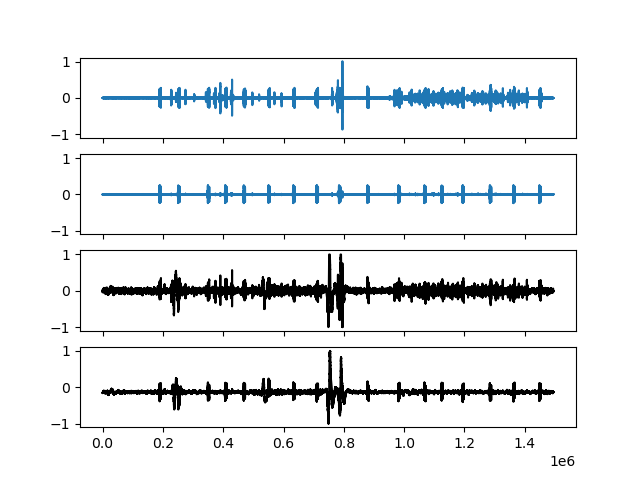

In [3]:
fig, axs = plt.subplots(nrows=4, sharex=True, sharey=True)

# filtered
axs[0].plot(bird_audio)
axs[1].plot(speaker_audio)

# raw
axs[2].plot(normalize(audio[:, 0]), color="k")
axs[3].plot(normalize(audio[:, 3]), color="k")

axs[0].set(
    # xlim=(9.79e5, 9.81e5),
    # xlim=(7.48e5, 7.55e5),
    # ylim=(-0.4, 1),
)

plt.show()

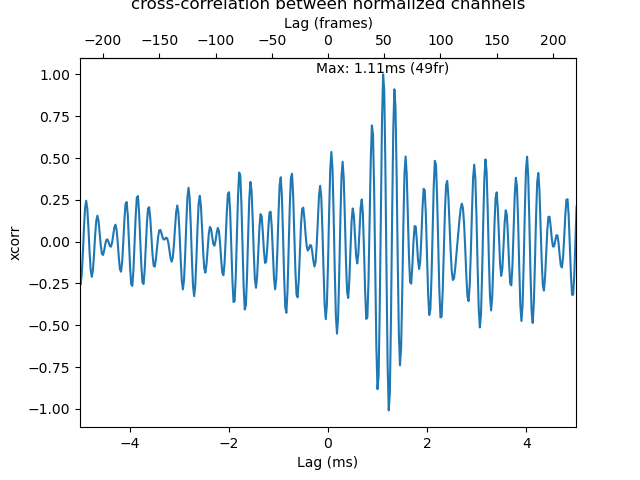

In [4]:
# warning! filtering makes a really big difference. high-amplitude/low frequency stuff really messes up XC
xcorr, lags = do_xcorr(bird_audio, speaker_audio)
fig, ax, i_max = xcorr_plot(xcorr, lags)

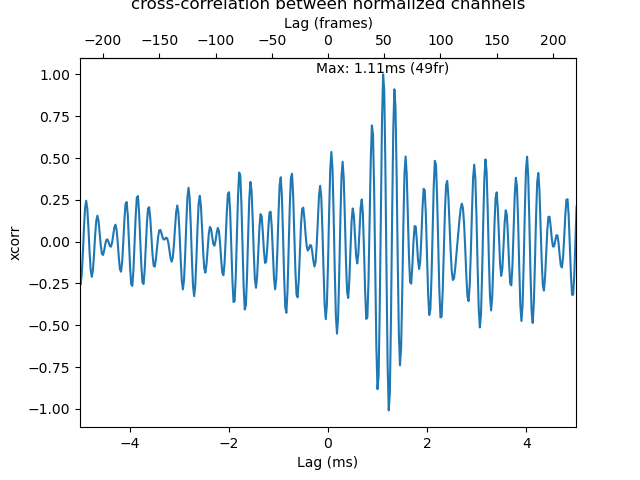

In [5]:
# now cut accordingly

neg = i_max > 0
i_max = abs(i_max.astype("int16"))

if i_max == 0:
    pass
elif i_max > 0:
    bird_audio_c = bird_audio[i_max:]
    speaker_audio_c = speaker_audio[: -1 * i_max]
else:
    bird_audio_c = bird_audio[: -1 * i_max]
    speaker_audio_c = speaker_audio[i_max:]
# check xcorr again

xcorr_c, lags_c = do_xcorr(bird_audio_c, speaker_audio_c)
fig, ax, i_max_c = xcorr_plot(xcorr, lags)

[Text(0.5, 1.0, 'aligned')]

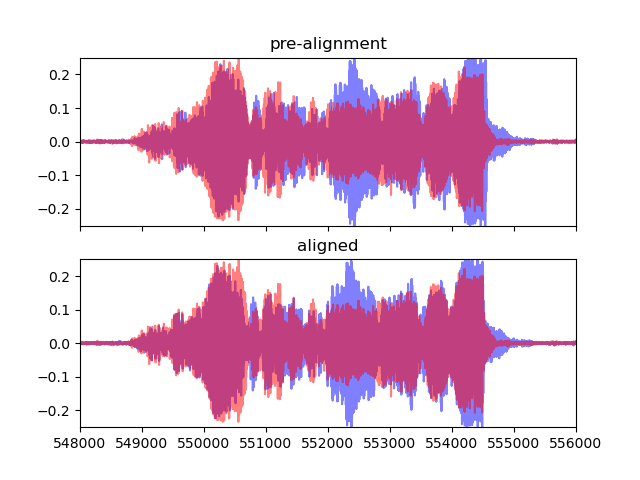

In [6]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True)

bird_color = "b"
speaker_color = "r"
alpha = 0.5

axs[0].plot(bird_audio, color=bird_color, alpha=alpha)
axs[0].plot(speaker_audio, color=speaker_color, alpha=alpha)


axs[1].plot(bird_audio_c, color=bird_color, alpha=alpha)
axs[1].plot(speaker_audio_c, color=speaker_color, alpha=alpha)

axs[0].set(xlim=(5.48e5, 5.56e5), ylim=(-0.25, 0.25), title="pre-alignment")

axs[1].set(title="aligned")

[Text(0.5, 1.0, 'xcorr post-alignment')]

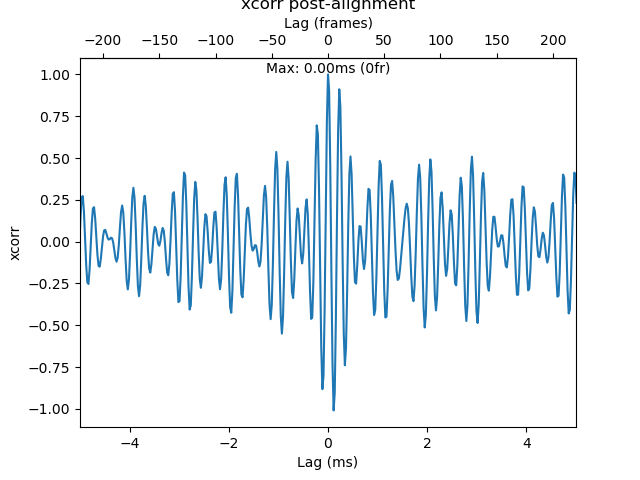

In [7]:
# xcorr, lags = do_xcorr(bird_audio, speaker_audio)
xcorr, lags = do_xcorr(bird_audio_c, speaker_audio_c)
fig, ax, i_max = xcorr_plot(xcorr, lags)

ax.set(title="xcorr post-alignment")

In [8]:
k = 1

bird_min_speaker = AudioObject(wav_subtract(bird_audio, speaker_audio, k), fs=44100)
speaker_min_bird = AudioObject(wav_subtract(speaker_audio, bird_audio, k), fs=44100)

for ao in (bird_min_speaker, speaker_min_bird):
    ao.audio_filt = ao.audio

    ao.make_spectrogram()

# wavfile.write(
#     "/Users/cirorandazzo/code/callback-analysis/tests/test_subtract.wav",
#     44100,
#     np.vstack([bird_audio, speaker_audio, bird_min_speaker, speaker_min_bird]).T,
# )

In [ ]:
ax = bird_min_speaker.plot_spectrogram(cmap="jet", vmin=0.7)
plt.colorbar(ax.images[0])

ax.set(
    xlim=(7, 11),
    ylim=(500, 15000),
    title="bird minus speaker",
)

In [ ]:
ax = speaker_min_bird.plot_spectrogram(cmap="jet", vmin=0.7)
plt.colorbar(ax.images[0])

ax.set(
    xlim=(7, 11),
    ylim=(500, 15000),
    title="speaker minus bird",
)

In [11]:
# animation of waveform

# import time
# import matplotlib.animation as animation

# xmin_start = 5  # where to start animation
# xrange = 0.004  # length of x-axis
# dx = 0.001
# x_stop = 35

# fig = plt.figure()
# ax = fig.subplots()

# x_time = np.arange(len(bird_audio)) / 44100
# ax.plot(x_time, bird_audio, label="bird mic")
# ax.plot(x_time, speaker_audio, label="speaker mic")

# ax.plot(x_time, bird_min_speaker, label="$B-S$")
# ax.plot(x_time, speaker_min_bird, label="$S-B$")

# ax.set_xlabel("Time since audio onset (s)")
# ax.legend(loc="upper right")
# ax.tick_params(
#     axis="x",
#     labelrotation=45,
# )


# def update_xlim(frame):
#     global xmin
#     global xrange
#     global dx
#     global ax

#     if frame == 0:
#         xmin = xmin_start
#     else:
#         xmin += dx

#     if frame % 10 == 0:
#         ax.set_title(f"Frame {frame}")

#     ax.set_xlim([xmin, xmin + xrange])

#     return ax


# n_frames = round((x_stop - xmin_start) / dx)
# # n_frames = 100

# sim = animation.FuncAnimation(
#     fig, update_xlim, frames=n_frames, interval=300, repeat=False
# )

# plt.show()